In [548]:
from collections import defaultdict 
import matplotlib.pyplot as plt
import geopy.distance as gd
import pandas as pd
import numpy as np

In [579]:
df = pd.read_csv('metrobike-2020.csv')
df.head()

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,bike_type
0,134867493,25,1/1/2020 0:16,1/1/2020 0:41,3063,34.048038,-118.253738,4491,34.047440,-118.247940,18419,30,One Way,Monthly Pass,electric
1,134867799,35,1/1/2020 0:24,1/1/2020 0:59,4285,NaN,NaN,4354,34.017681,-118.409081,15661,1,One Way,One Day Pass,smart
2,134868104,37,1/1/2020 0:31,1/1/2020 1:08,4344,34.014309,-118.491341,4322,34.005871,-118.429161,15848,1,One Way,Walk-up,smart
3,134868103,36,1/1/2020 0:32,1/1/2020 1:08,4344,34.014309,-118.491341,4322,34.005871,-118.429161,16053,1,One Way,Walk-up,smart
4,134868102,35,1/1/2020 0:33,1/1/2020 1:08,4344,34.014309,-118.491341,4322,34.005871,-118.429161,15694,1,One Way,Walk-up,smart


In [3]:
# Number of rides in 2020
df.shape[0]

209974

In [4]:
df.columns

Index(['trip_id', 'duration', 'start_time', 'end_time', 'start_station',
       'start_lat', 'start_lon', 'end_station', 'end_lat', 'end_lon',
       'bike_id', 'plan_duration', 'trip_route_category', 'passholder_type',
       'bike_type'],
      dtype='object')

In [5]:
# Clean unecessary columns
columns = ['duration', 'start_time', 'end_time', 'start_station', 'start_lat', 'start_lon', 'end_station', 'end_lat', 'end_lon', 'bike_id', 'bike_type']
df = df[columns]
df.head()

,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,bike_type
0,25,1/1/2020 0:16,1/1/2020 0:41,3063,34.048038,-118.253738,4491,34.047440,-118.247940,18419,electric
1,35,1/1/2020 0:24,1/1/2020 0:59,4285,NaN,NaN,4354,34.017681,-118.409081,15661,smart
2,37,1/1/2020 0:31,1/1/2020 1:08,4344,34.014309,-118.491341,4322,34.005871,-118.429161,15848,smart
3,36,1/1/2020 0:32,1/1/2020 1:08,4344,34.014309,-118.491341,4322,34.005871,-118.429161,16053,smart
4,35,1/1/2020 0:33,1/1/2020 1:08,4344,34.014309,-118.491341,4322,34.005871,-118.429161,15694,smart


In [6]:
# According to station info dataset:
# 4285,Metro Bike Share Free Bikes,2/27/2019,Free Bikes,Active
# 4286,Metro Bike Share Out of Service Area Smart Bike,2/27/2019,Free Bikes,Active
# 3000,Virtual Station,7/7/2016,N/A,Active
# I suppose those are virtual and free bike stations (?)

df_null = df[df.isnull().any(axis=1)]
nan_stations = df_null.start_station[df_null['start_lat'].isnull()].unique()
nan_stations

array([4285, 4286, 3000])

In [402]:
# Remove stations without geolocation
df = df.dropna()

In [8]:
# Total bikes within all stations and Nº of stations
print(len(df['bike_id'].unique()))
df['start_station'].unique().shape[0]

3983


263

In [9]:
# Percentage of rides with each model of bike
df['bike_type'].value_counts(normalize=True)

standard    0.511699
electric    0.394669
smart       0.093633
Name: bike_type, dtype: float64

In [10]:
# Mean duration of a bike ride
df['duration'].mean()

31.95790634851989

In [11]:
# Percentage of rides starting at all stations
df['start_station'].value_counts(normalize=True)

3005    0.049584
3035    0.031012
3030    0.026005
3006    0.020219
3014    0.019950
          ...   
4557    0.000094
4573    0.000069
4577    0.000069
4569    0.000063
4559    0.000044
Name: start_station, Length: 263, dtype: float64

In [12]:
# Percentage of rides ending at all stations
df['end_station'].value_counts(normalize=True)

3005    0.051351
3035    0.031269
3014    0.024243
3030    0.020157
3006    0.020107
          ...   
4577    0.000088
4573    0.000075
4557    0.000069
4569    0.000069
4559    0.000063
Name: end_station, Length: 263, dtype: float64

In [13]:
# Calculate distance using lat-long
def get_distance(coords):
    return gd.geodesic((coords[0], coords[1]), (coords[2], coords[3])).km

In [14]:
# Create new distance column
columns = ['start_lat', 'start_lon', 'end_lat', 'end_lon']
df['distance'] = df.apply(lambda x: get_distance(x[columns]), axis=1)

In [15]:
# The duration and distance values of rides are very discrepant, specially because some rides start and end at same station. Eventually there are cases where people stay with the bike an entire day and then return then to a station, which doesn't reflect the real time they spending at the ride.
# In this sense, we decided to ignore those cases when calculating the mean speed of each bycicle model.
time_space = df.iloc[:, [0, 10, 11]]
time_space.describe()

,duration,distance
count,159549.000000,159549.000000
mean,31.957906,2.855966
std,96.622064,125.211155
min,1.000000,0.000000
25%,7.000000,0.401246
50%,14.000000,0.915194
75%,26.000000,1.711136
max,1440.000000,9812.232301


In [126]:
# Filtering discrepant cases, now standard deviation and mean are more precise
time_space_filtered.describe()

,duration,distance
count,93263.000000,93263.000000
mean,9.684870,1.272555
std,5.072324,0.855166
min,1.000000,0.106798
25%,5.000000,0.675445
50%,9.000000,1.038416
75%,14.000000,1.647928
max,20.000000,8.567865


In [101]:
# sorted_duration = time_space_filtered.groupby('distance').count()
# sorted_duration.sort_values(by='duration', ascending=False)

In [365]:
def get_speed(space, time, unit):

    if unit == 'km/min': return space / time
    if unit == 'km/h'  : return space / (time / 60)
    if unit == 'm/s'   : return (space * 1000) / (time * 60)

In [399]:
# Calculate the average speed of each bike model using V = ΔS/ΔT
unit = 'km/min'
intervals = [(15, 3), (30, 6), (45, 9), (120, 12)]

avg_speed = pd.DataFrame()
for x, y in enumerate(intervals):
    if x == 0:
        time_space_filtered = time_space.loc[(df.duration > 0) & (df.duration <= y[0]) 
                                           & (df.distance > 0) & (df.distance <= y[1])]
    else:
        time_space_filtered = time_space.loc[(df.duration > intervals[x-1][0]) & (df.duration <= y[0]) 
                                           & (df.distance > intervals[x-1][1]) & (df.distance <= y[1])]

    time_space_filtered['speed'] = time_space_filtered.apply(lambda x: get_speed(x['distance'], x['duration'], unit=unit), axis=1)
    bike_speed = time_space_filtered.groupby('bike_type').mean()
    avg_speed[str(y)] = bike_speed['speed']

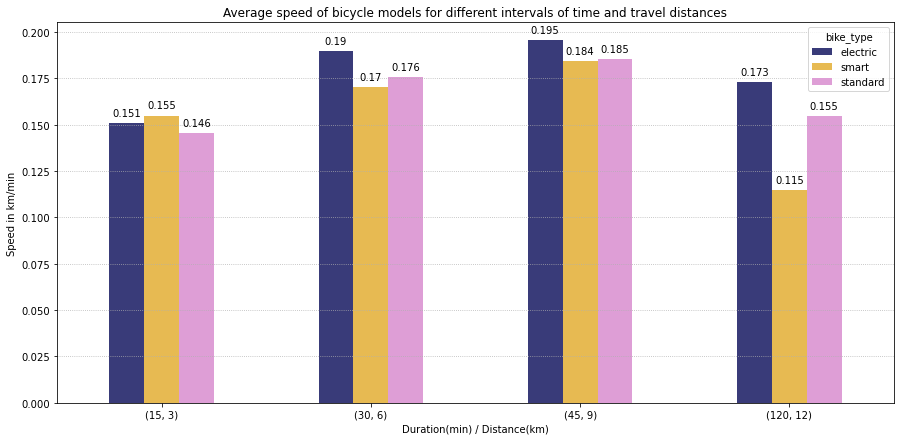

In [400]:
title = 'Average speed of bicycle models for different intervals of time and travel distances'
xlabel = 'Duration(min) / Distance(km)'

ax = avg_speed.T.plot(kind='bar', figsize=(15, 7), xlabel=xlabel, ylabel='Speed in ' + unit, colormap='tab20b', rot=0, title=title)
for p in ax.patches:                 
    ax.annotate(round(p.get_height(),3), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
ax.grid(linestyle=':', axis='y')

In [432]:
# Normalize rides from each station
def normalize_by_group(df, group):
    groups = df.
    mean = groups.transform(np.mean)
    std = groups.transform(np.std)
    return (df[mean.columns] - mean) / std

In [621]:
# Ignore rides that end at same station
group = ['start_station', 'end_station']
# Create frequency matrix of start-end stations
stations = df.loc[df.start_station != df.end_station].groupby(group).size()
# stations.apply(lambda x: print(x))
# stations.loc[3005]
# for index in stations.index[:4]:
#     print(index)
# stations.index